In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scanpy as sc
from scipy.spatial.distance import cdist
from scipy.stats import norm
import torch

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")

# Like colorblind_palette[4] for control, colorblind_palette[0] for test

## Loading RF Models & Datasets

In [3]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_apical_unfiltered = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/apical_basal_data/moor_data_apical_basal_embeddings_adata_all_nr_spots.h5ad")
adata_apical = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/apical_basal_data/moor_data_apical_basal_embeddings_adata.h5ad")

In [8]:
adata_apical_unfiltered

AnnData object with n_obs × n_vars = 39498 × 15
    obs: 'pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'blur_interval', 'corresponding_dapis', 'corresponding_cells', 'original_image_paths'
    obsm: 'latent'

In [10]:
adata_apical_unfiltered.obs['cell_id'].unique()

['44_240', '44_241', '44_242', '44_243', '44_244', ..., '60_95', '60_96', '60_97', '60_98', '60_99']
Length: 408
Categories (408, object): ['44_240', '44_241', '44_242', '44_243', ..., '60_165', '60_166', '60_167', '60_168']

In [4]:
adata_split_cellID = initialize_adata(adata_split_cellID)
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

In [91]:
palette_colorblind = [colorblind_palette[4], colorblind_palette[0]]

# Chamfer Distance

In [5]:
strength = 'strong'
count = '10-30'
sample = 5

pattern = create_simulated_gene(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample, random_seed=True)
control = create_simulated_gene(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample, random_seed=True)

#### permutation function

In [11]:
from power_analysis import latent_space_statistic

# Perform permutation test
p_value, observed_statistic, permuted_statistics = latent_space_statistic(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999, return_distances=True, for_power_purposes=False)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 107.39544763937593
P-value: 0.003968253968253968


In [12]:
from power_analysis import latent_space_statistic

# Perform permutation test
p_value, observed_statistic, permuted_statistics = latent_space_statistic(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999, return_distances=True, for_power_purposes=False)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 107.39544763937593
P-value: 0.011904761904761904


In [206]:
# Used to generate descriptive statistics in Table 3
n_spots = adata_apical[adata_apical.obs['genes']=='Slc39a14'].obs['n_spots'].to_numpy()
print(len(n_spots))
print(np.mean(n_spots))
print(np.median(n_spots))
print(np.std(n_spots))
print(np.min(n_spots))
print(np.max(n_spots))

389
5.4910025706940875
5.0
3.7633117658910704
1
23


Used different map_interval() and subset_power() methods from the dataprep.py so that I could easier change the intervals needed for the validation on the biological dataset

In [71]:
def map_interval(interval):
    if interval in ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']:
        return '0-100'
    else:
        return None
    
adata_test.obs['apob_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)


In [12]:
def subset_power(adata, pattern: str = 'pericellular', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5, random_seed: bool = False):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['apob_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()

    if random_seed == True:
        subset = adata_filtered.obs.sample(n=sample_size, random_state = seed) 
    else:
        subset = adata_filtered.obs.sample(n=sample_size)
    
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)]


    return adata_subset

In [57]:
adata_test.obs['apob_count'].value_counts()

20-50    67489
0-20     36383
Name: apob_count, dtype: int64

In [46]:
len(adata_apical[adata_apical.obs['genes']=='Cdkn1a'])
#Slc39a14

376

In [68]:
pattern = adata_apical_unfiltered[adata_apical_unfiltered.obs['genes']=='Apob'].obsm['latent']
control = subset_power(adata_test, pattern = 'random', mixed_patterns = False, rna_count = '10-40', sample_size = len(pattern), random_seed=True)

In [69]:
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern, 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 35.97571563720703
P-value: 0.0001


In [19]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern_balanced_singlejob.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced_singlejob = pickle.load(p)

In [18]:
from latent_statistics import permutation_test
from scipy.stats import ks_2samp
import pickle

In [70]:
pattern_score = rf_pattern_balanced_singlejob.predict_proba(pattern)[:,1]
control_score = rf_pattern_balanced_singlejob.predict_proba(control.obsm["latent"])[:,1]

statistic, pvalue = ks_2samp(pattern_score, control_score)
print(f"Observed KS statistic: {statistic}")
print(f"P-value: {pvalue}")

Observed KS statistic: 0.6748768472906403
P-value: 3.421253042870827e-88


In [101]:
test1 = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = '10-30', sample_size = 70)

In [7]:
colorblind_palette = sns.color_palette("colorblind")
colorblind_palette[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

In [188]:
plt.rcParams['grid.alpha'] = 0.4

34
31


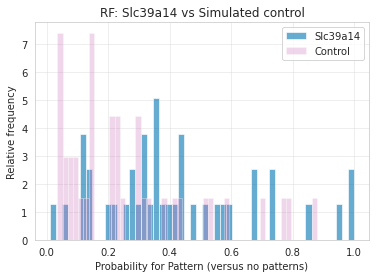

In [274]:

print(len(np.unique(pattern_score)))
print(len(np.unique(control_score)))

#plt.hist(random_low['prob_pattern'], bins=30, alpha=0.4, label='Random', density=True)
plt.hist(pattern_score, bins=50, alpha=0.6, label='Slc39a14', density=True, color=colorblind_palette[0])
plt.hist(control_score, bins=50, alpha=0.3, label='Control', density=True, color=colorblind_palette[4])


plt.title(f"RF: Slc39a14 vs Simulated control")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pattern (versus no patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [114]:
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern, 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 67.43435668945312
P-value: 0.0001


In [ ]:
from dataprep import subset_power_analysis

In [9]:
pattern = subset_power_analysis(adata_test, mixed_patterns = True, rna_count = '0-10',pattern_strength='intermediate', sample_size = 600, random_seed=True)
control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = '0-10', sample_size = 600, random_seed=True)

In [10]:
from latent_statistics import permutation_test
#permutation_test(pattern, control, n_permutations: int = 1000)
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999, return_distances=True)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 21.393900354491393
P-value: 0.0001


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


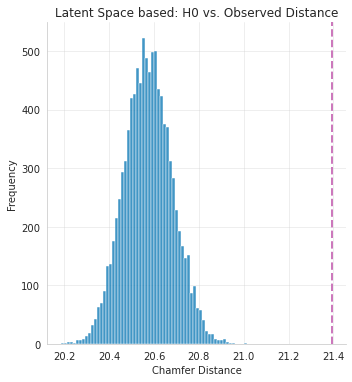

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram with seaborn
sns.displot(permuted_statistics, bins='auto', kde=False)

# Add vertical line at observed statistic
plt.axvline(x=observed_statistic, color=colorblind_palette[4], linestyle='dashed', linewidth=2)

# Add labels and title
plt.title('Latent Space based: H0 vs. Observed Distance')
plt.xlabel('Chamfer Distance')
plt.ylabel('Frequency')

# Show plot
plt.show()